# Diamonds price prediction

## Packages

In [80]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) # Seaborn has a problem with it plotting function

sns.set_theme(font_scale=1.25)

## Notebook configurations

In [81]:
import os

KAGGLE_INPUT = '/kaggle/input'
DATASET_BASE_DIR = os.path.join(KAGGLE_INPUT, 'diamonds')

DATASET_FILE = os.path.join(DATASET_BASE_DIR, 'diamonds.csv')

## Load dataset

In [82]:
df = pd.read_csv(DATASET_FILE)  # Load the dataset from csv file

In [83]:
df.sample(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
29382,29383,0.31,Ideal,E,SI1,62.7,57.0,698,4.32,4.29,2.70
4860,4861,1.00,Premium,I,SI2,61.6,59.0,3712,6.34,6.41,3.93
50305,50306,0.31,Ideal,I,VS1,61.7,55.0,544,4.39,4.36,2.70
17981,17982,1.23,Premium,E,SI1,59.2,62.0,7274,7.05,7.00,4.16
35321,35322,0.31,Very Good,F,VVS1,61.8,59.0,897,4.33,4.35,2.68


In [84]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [85]:
df.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object')

In [86]:
df.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

## 1. Dataset Description and Problem Definition


### Problem Definition
We want from given features to predict the price of the diamond

### Dataset Description 
| Feature  | Description                                                                 |
|----------|-----------------------------------------------------------------------------|
| `carat`  | Weight of the diamond (range: 0.2–5.01 carats)                              |
| `cut`    | Quality of the cut. Categories: Fair, Good, Very Good, Premium, Ideal       |
| `color`  | Diamond colour, from J (worst) to D (best). Categories: J, I, H, G, F, E, D |
| `clarity`| Measurement of how clear the diamond is. Categories: I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best) |
| `depth`  | Total depth percentage = 2 × z / (x + y) (range: 43–79)                     |
| `table`  | Width of top of diamond relative to widest point (range: 43–95)            |
| `price`  | Price in US dollars (range: \$326–\$18,823)                                 |
| `x`      | Length in mm (range: 0–10.74)                                               |
| `y`      | Width in mm (range: 0–58.9)                                                 |
| `z`      | Depth in mm (range: 0–31.8)                                                 |



## 2. Exploratory Data Analysis (EDA)

In [87]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [88]:
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [89]:
sum(df.duplicated()) == 0

False

In [90]:
df.isna().any()

carat      False
cut        False
color      False
clarity    False
depth      False
table      False
price      False
x          False
y          False
z          False
dtype: bool

In [91]:
print(df['cut'].unique())
print(df['cut'].value_counts())

['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
cut
Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: count, dtype: int64


In [92]:
print(df['color'].unique())
print(df['color'].value_counts())

['E' 'I' 'J' 'H' 'F' 'G' 'D']
color
G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: count, dtype: int64


In [93]:
print(df['clarity'].unique())
print(df['clarity'].value_counts())

['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']
clarity
SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: count, dtype: int64


<Axes: xlabel='carat'>

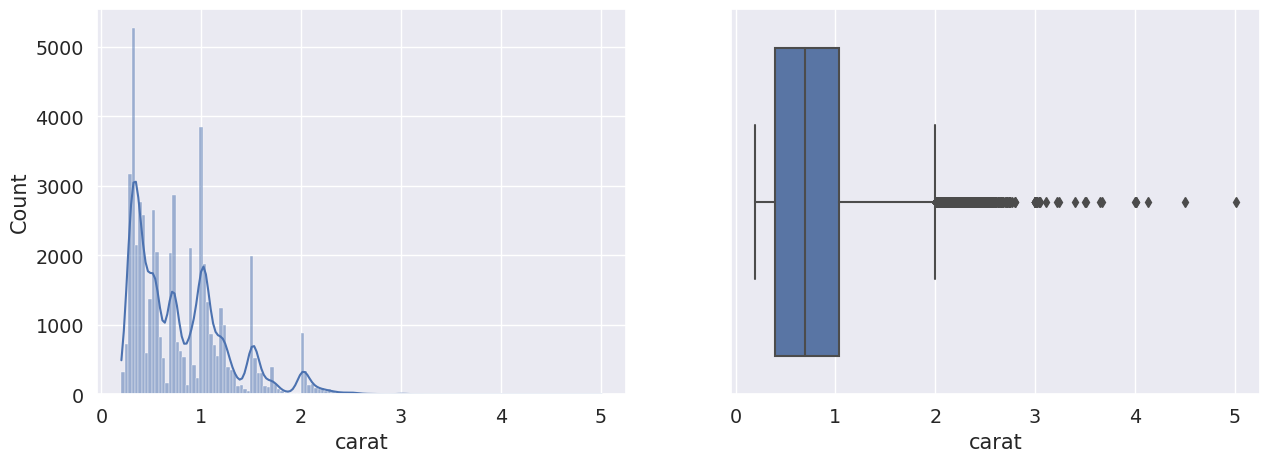

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=df, x="carat", kde=True, ax=axes[0])
sns.boxplot(x=df["carat"], ax=axes[1])

<Axes: xlabel='depth'>

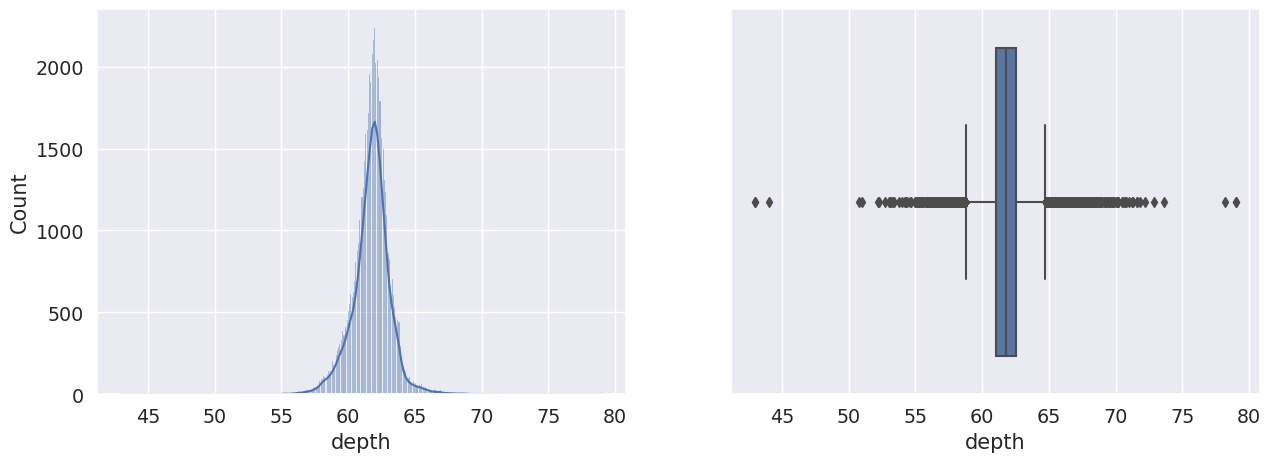

In [95]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=df, x="depth", kde=True, ax=axes[0])
sns.boxplot(x=df["depth"], ax=axes[1])

<Axes: xlabel='table'>

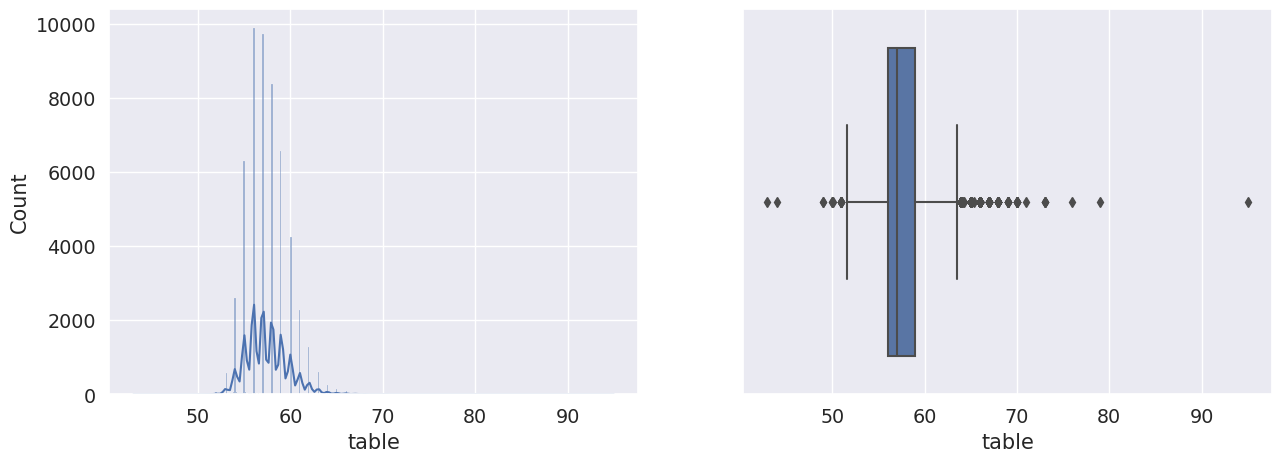

In [96]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=df, x="table", kde=True, ax=axes[0])
sns.boxplot(x=df["table"], ax=axes[1])

<Axes: xlabel='x'>

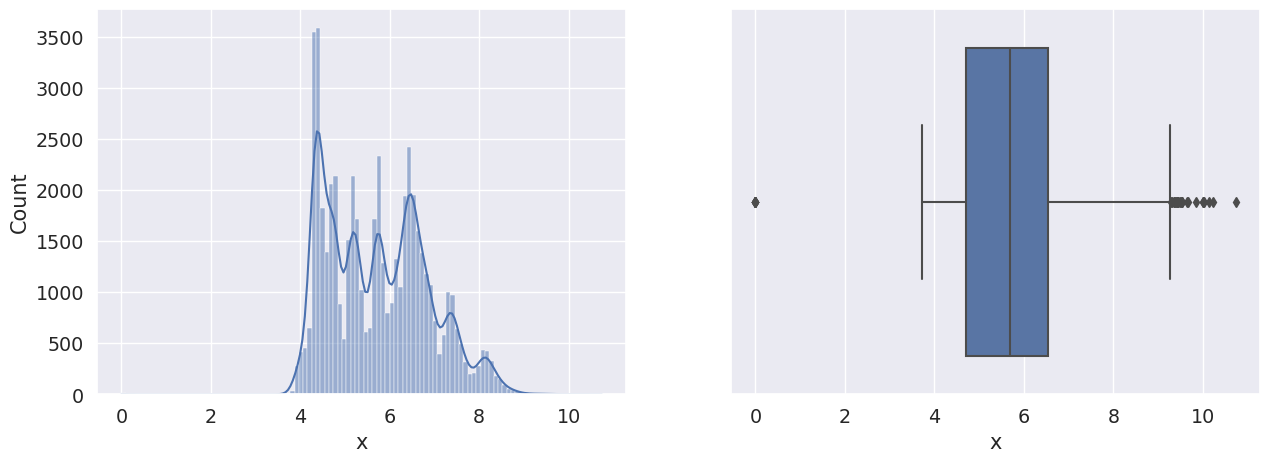

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=df, x="x", kde=True, ax=axes[0])
sns.boxplot(x=df["x"], ax=axes[1])

<Axes: xlabel='y'>

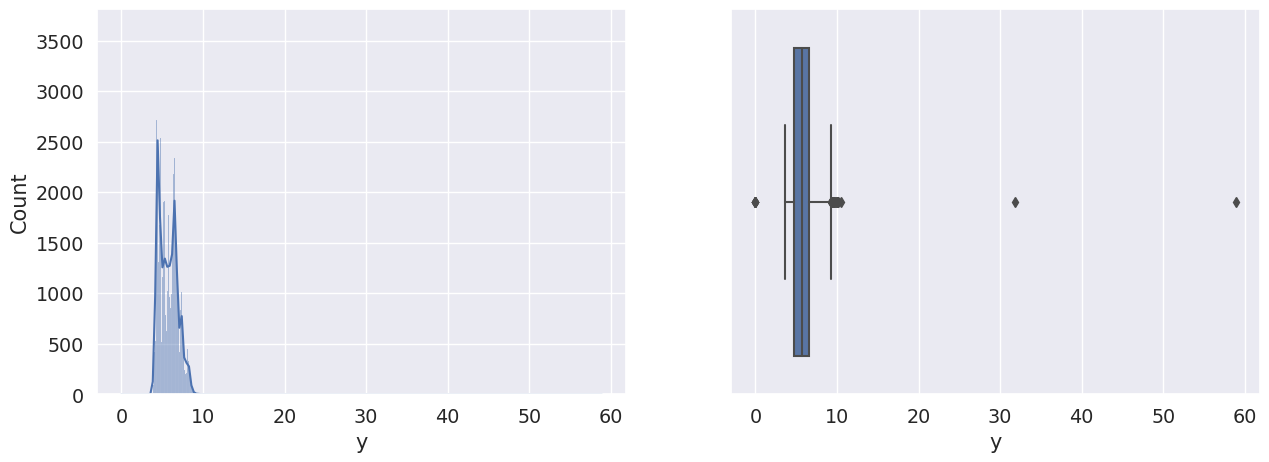

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=df, x="y", kde=True, ax=axes[0])
sns.boxplot(x=df["y"], ax=axes[1])

<Axes: xlabel='z'>

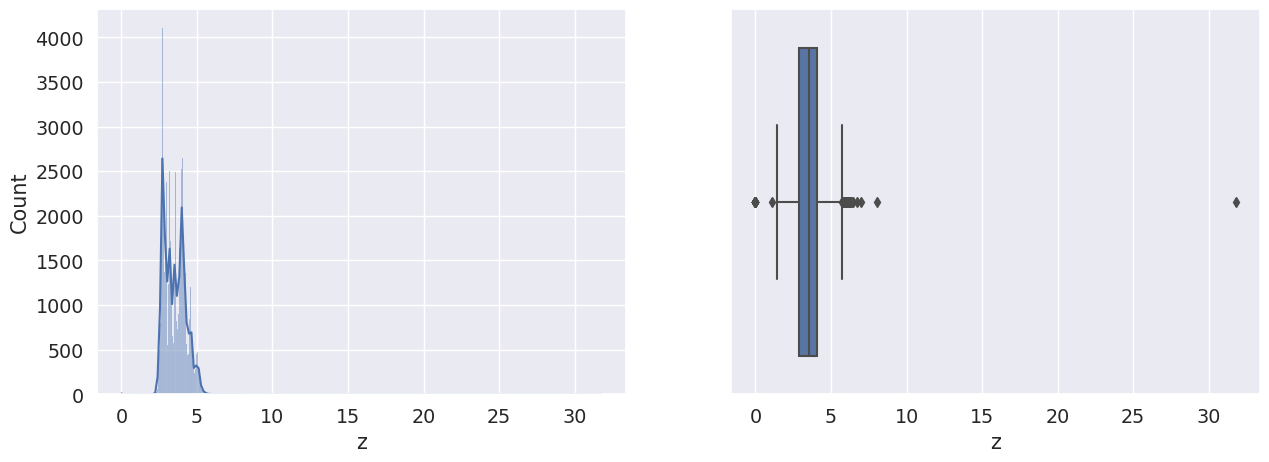

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=df, x="z", kde=True, ax=axes[0])
sns.boxplot(x=df["z"], ax=axes[1])

<Axes: xlabel='price'>

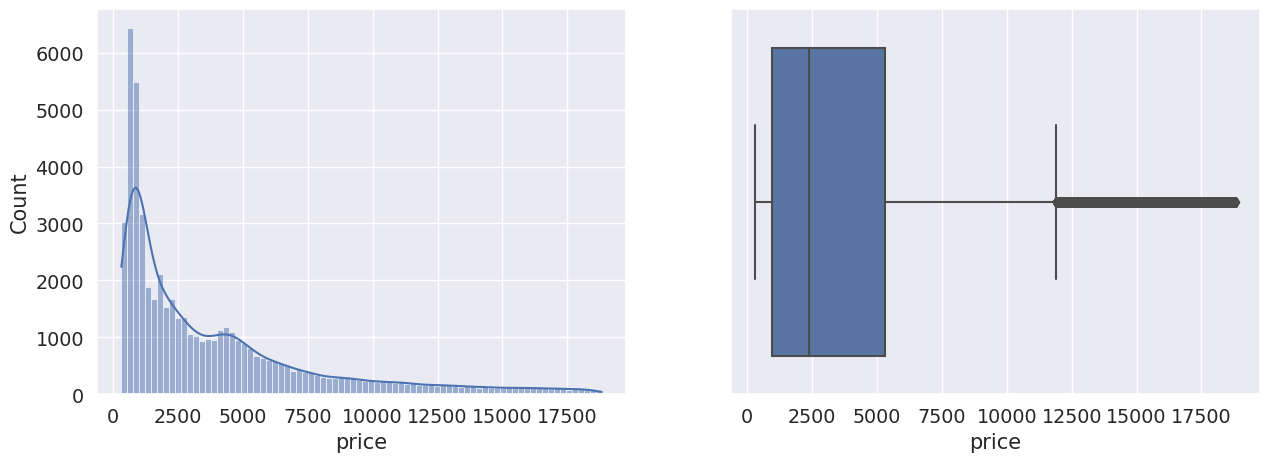

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=df, x="price", kde=True, ax=axes[0])
sns.boxplot(x=df["price"], ax=axes[1])

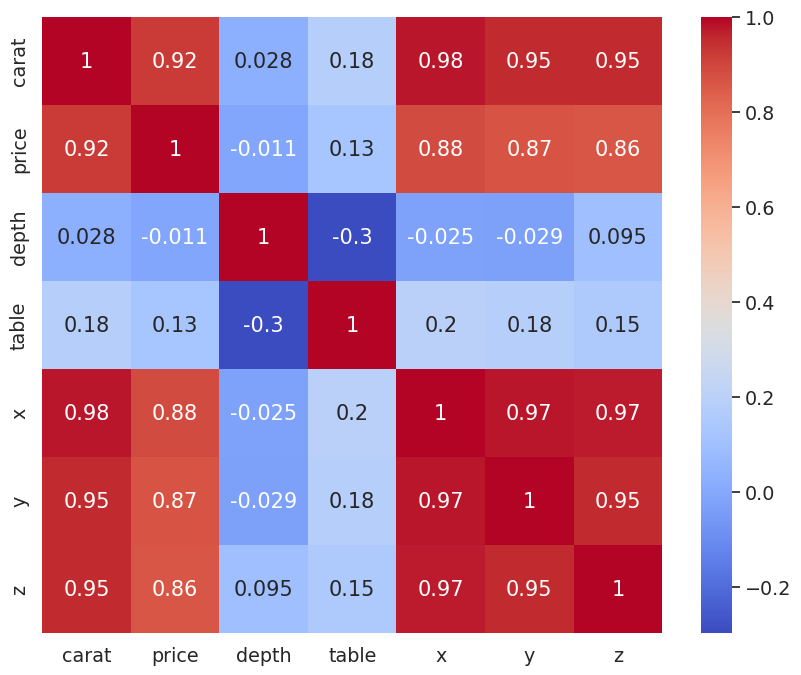

In [101]:
plt.figure(figsize=(10, 8))
correlation_matrix = df[["carat", "price", "depth", "table", "x", "y", "z"]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

| Observation                                                                 | Notes                                                                                    |
|-----------------------------------------------------------------------------|------------------------------------------------------------------------------------------|
| `carat`, `x`, `y`, `z` have high correlation with `price`                   | These are strong predictors of diamond price                                             |
| `x`, `y`, `z` are highly correlated with each other                         | Consider combining them into a single feature like **volume** (`x * y * z`)              |
| `depth`, `table` have low correlation with `price`                          | These features can be removed to reduce noise                                            |
| `carat`, `price`, `depth`, `table`, `x`, `y`, `z` contain outliers          | Need to remove outlairs                                                                  |
| Apply log transformation to `carat`                                         | To reduce skew                                                                           |
| `cut`, `clarity`, `color` are labels                                        | Need label encoding                                                                      |


## 3. Data Cleaning

### Drop less correlated featurs

In [102]:
df.drop(columns=["depth", "table"], inplace=True)
df.sample(5)

,carat,cut,color,clarity,price,x,y,z
9973,0.72,Ideal,E,VVS1,4702,5.75,5.77,3.55
14029,1.22,Ideal,H,SI2,5703,6.90,5.92,4.22
31934,0.30,Ideal,F,VS2,776,4.37,4.34,2.63
738,0.31,Ideal,H,VS1,557,4.33,4.37,2.69
38810,0.31,Ideal,G,VVS1,1046,4.36,4.30,2.68


### Combine `x`, `y`, `z` features

In [103]:
df['volume'] = df['x'] * df['y'] * df['z']
df.drop(columns=['x', 'y', 'z'], inplace=True)
df = df[(df['price'] > 0) & (df['volume'] > 0)]
df.sample(5)

,carat,cut,color,clarity,price,volume
38447,0.54,Ideal,G,SI2,1028,89.131752
16581,1.10,Ideal,F,SI1,6621,183.122694
4960,0.90,Good,I,IF,3734,140.684390
49449,0.71,Very Good,I,VS2,2111,120.049020
53383,0.70,Ideal,F,SI1,2662,116.430600


### Log transformation

In [104]:
df['carat'] = np.log(df['carat'])
df['volume'] = np.log(df['volume'])

In [105]:
df.sample(5)

,carat,cut,color,clarity,price,volume
20670,0.444686,Premium,H,SI2,8954,5.561169
28747,-1.171183,Ideal,E,VS2,680,3.932179
11777,0.182322,Very Good,J,SI1,5083,5.289149
52573,-0.105361,Fair,I,SI2,2536,4.926854
41251,-0.967584,Very Good,I,SI2,500,4.105531


### Removing outlairs

In [106]:
z_scores = df[['carat', 'volume']].apply(zscore)

df = df[(z_scores['carat'].abs() < 3) & (z_scores['volume'].abs() < 3)]

### Label encoding

In [107]:
cut_order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
color_order = ['J', 'I', 'H', 'G', 'F', 'E', 'D'] 
clarity_order = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']

df['cut'] = pd.Categorical(df['cut'], categories=cut_order, ordered=True).codes
df['color'] = pd.Categorical(df['color'], categories=color_order, ordered=True).codes
df['clarity'] = pd.Categorical(df['clarity'], categories=clarity_order, ordered=True).codes

### Results

<Axes: xlabel='carat'>

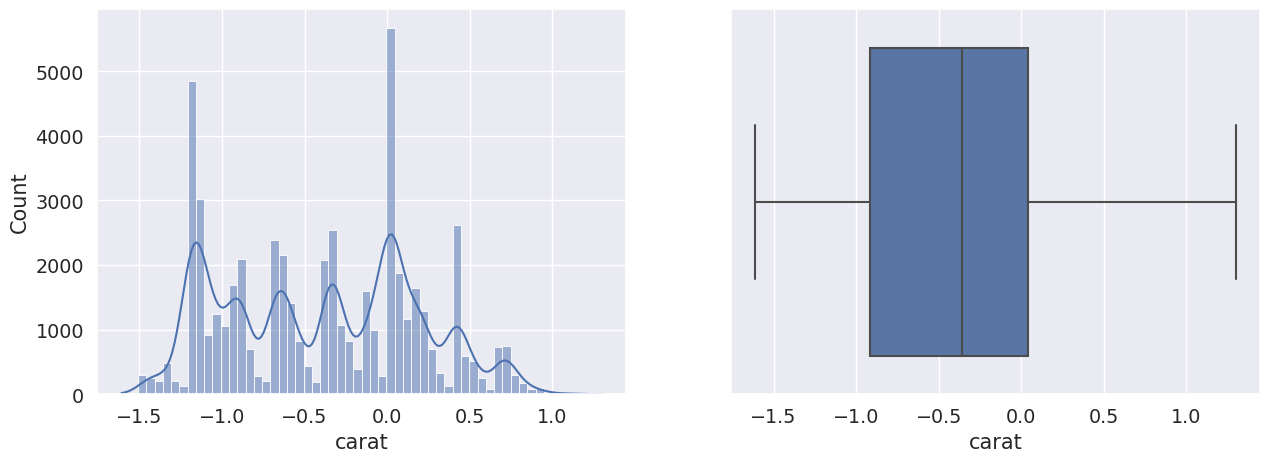

In [108]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=df, x="carat", kde=True, ax=axes[0])
sns.boxplot(x=df["carat"], ax=axes[1])

<Axes: xlabel='volume'>

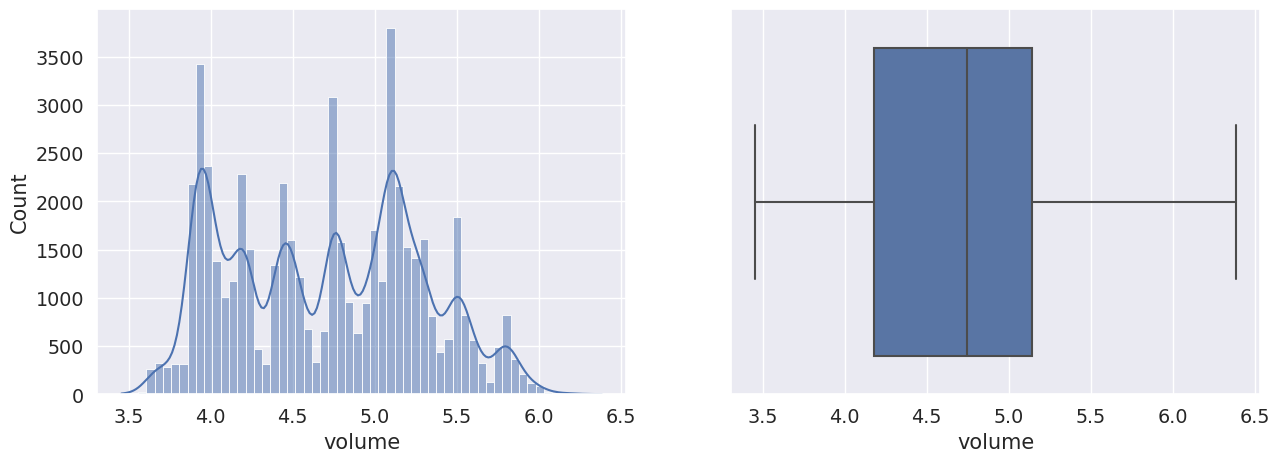

In [109]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=df, x="volume", kde=True, ax=axes[0])
sns.boxplot(x=df["volume"], ax=axes[1])

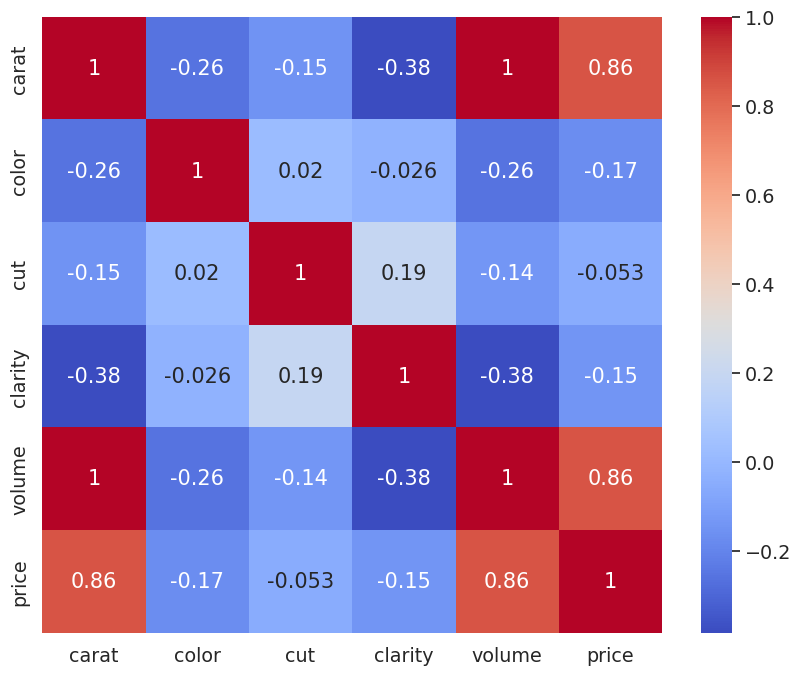

In [110]:
plt.figure(figsize=(10, 8))
correlation_matrix = df[["carat", "color", "cut", "clarity", "volume", "price"]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

### Note
- We can take either `volumne` or `carat` as feature

In [111]:
df.drop(columns=['volume'], inplace=True)

## 4. Preprocessing

In [112]:
X = df.drop(columns=['price'])
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [113]:
scaler = StandardScaler()

X_train['carat'] = scaler.fit_transform(X_train[['carat']])
X_test['carat'] = scaler.transform(X_test[['carat']])

## 5. Modeling and Evaluation

In [114]:
results = {}

In [115]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

results['linear'] = {
    'model': model,
    'MSE': mse,
    'RMSE': rmse,
    'R²': r2,
    'R²_adj': adj_r2,
    'y_pred': y_pred
}

In [116]:
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

results['ridge'] = {
    'model': model,
    'MSE': mse,
    'RMSE': rmse,
    'R²': r2,
    'R²_adj': adj_r2,
    'y_pred': y_pred
}

In [117]:
model = Lasso(alpha=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

results['lasso'] = {
    'model': model,
    'MSE': mse,
    'RMSE': rmse,
    'R²': r2,
    'R²_adj': adj_r2,
    'y_pred': y_pred
}

In [118]:
model = ElasticNet(alpha=0.1, l1_ratio=0.5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

results['elasticnet'] = {
    'model': model,
    'MSE': mse,
    'RMSE': rmse,
    'R²': r2,
    'R²_adj': adj_r2,
    'y_pred': y_pred
}

In [119]:
metrics_df = pd.DataFrame({k: {m: v[m] for m in ['MSE', 'RMSE', 'R²', 'R²_adj']} for k, v in results.items()}).T
print(metrics_df)

                     MSE         RMSE        R²    R²_adj
linear      3.412675e+06  1847.342651  0.779447  0.779365
ridge       3.412671e+06  1847.341568  0.779447  0.779365
lasso       3.412675e+06  1847.342801  0.779447  0.779365
elasticnet  3.449860e+06  1857.379910  0.777044  0.776961


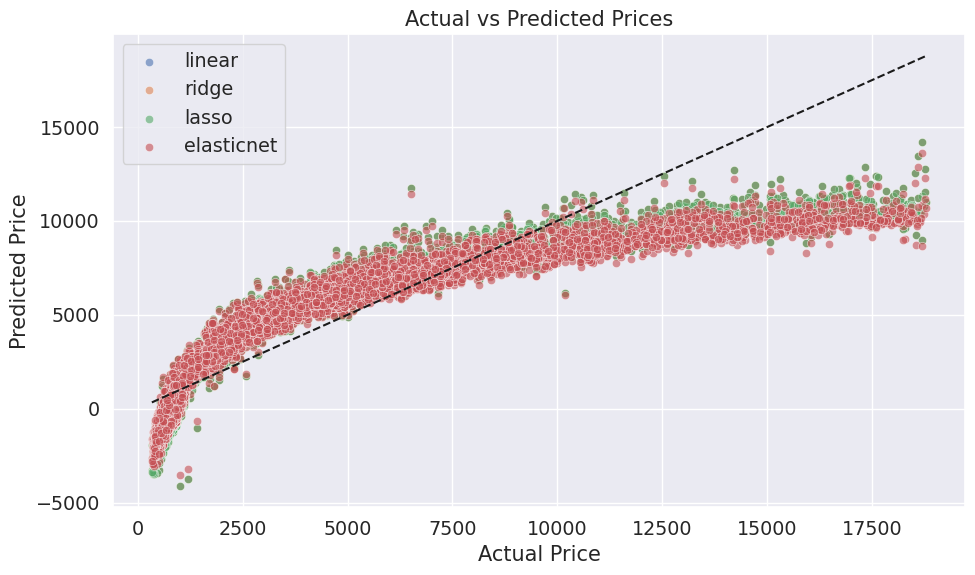

In [120]:
plt.figure(figsize=(10, 6))
for name in ['linear', 'ridge', 'lasso', 'elasticnet']:
    sns.scatterplot(x=y_test, y=results[name]['y_pred'], label=name, alpha=0.6)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

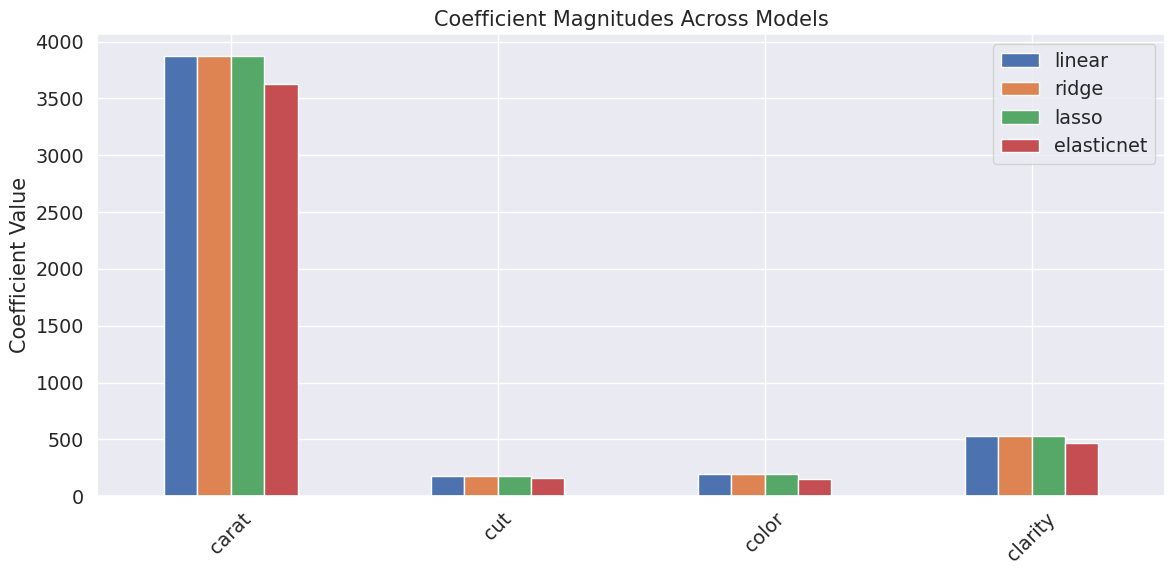

In [121]:
coef_df = pd.DataFrame({name: model['model'].coef_ for name, model in results.items()}, index=X.columns)

coef_df.plot(kind='bar', figsize=(12, 6))
plt.title("Coefficient Magnitudes Across Models")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## 6. Interpretation and Conclusion

### Model

| Model        | MSE           | RMSE     | R²     | R² Adj | Notes                                                                 |
|--------------|---------------|----------|--------|--------|-----------------------------------------------------------------------|
| Linear       | 3.41e+06      | 1847.34  | 0.7794 | 0.7793 | Best overall; simple and interpretable                               |
| Ridge        | 3.41e+06      | 1847.34  | 0.7794 | 0.7793 | Very similar to Linear; regularization had minimal impact            |
| Lasso        | 3.41e+06      | 1847.34  | 0.7794 | 0.7793 | Same as Linear; did not zero out features (all features retained)    |
| ElasticNet   | 3.45e+06      | 1857.38  | 0.7770 | 0.7769 | Slightly worse; over-penalized coefficients                          |

### Conclusion
- **Best model**: `Linear Regression` lowest error, highest $R^2$.
